In [2]:
import pandas as pd
import csv

def nctid2label_dict():
    nctid2outcome = dict() 
    nctid2label = dict() 
    with open("IQVIA/outcome2label.txt", 'r') as fin: 
        lines = fin.readlines() 
    outcome2label = {line.split('\t')[0]:int(line.strip().split('\t')[1]) for line in lines}

    with open("IQVIA/trial_outcomes_v1.csv", 'r') as csvfile: 
        csvreader = list(csv.reader(csvfile))[1:]
    nctid2outcome = {row[0]:row[1] for row in csvreader}

    for nctid, outcome in nctid2outcome.items():
        nctid2label[nctid] = outcome2label[outcome]

    return nctid2label 

def nctid2label_dict2():
    outcome2label = pd.read_csv("IQVIA/outcome2label.txt", sep='\t', engine='python', header=None)
    outcome2label.columns=['trialOutcome', 'label']
    nctid2outcome = pd.read_csv("IQVIA/trial_outcomes_v1.csv", sep=',', engine='python')

    nctid2label = nctid2outcome.merge(outcome2label, on='trialOutcome', how='left')
    return {nctid2label['studyid'].values[i] : nctid2label['label'].values[i] for i in range(len(nctid2label))}
print(nctid2label_dict()==nctid2label_dict2()) # True

def load_disease2icd():
    disease2icd = dict()
    with open('data/diseases.csv', 'r') as csvfile:
        rows = list(csv.reader(csvfile, delimiter = ','))[1:]
    for row in rows:
        disease = row[0]
        icd = row[1]
        disease2icd[disease] = icd
    return disease2icd 

def load_disease2icd2():
    data = pd.read_csv('data/diseases.csv')
    return {data['disease'].values[i] : data['icd'].values[i] for i in range(len(data))}
print(load_disease2icd2() == load_disease2icd())



True
True


In [1]:
from xml.etree import ElementTree
import csv

def nctid2label_dict():
    nctid2outcome = dict() 
    nctid2label = dict() 
    with open("IQVIA/outcome2label.txt", 'r') as fin: 
        lines = fin.readlines() 
        outcome2label = {line.split('\t')[0]:int(line.strip().split('\t')[1]) for line in lines}

    with open("IQVIA/trial_outcomes_v1.csv", 'r') as csvfile: 
        csvreader = list(csv.reader(csvfile))[1:]
        nctid2outcome = {row[0]:row[1] for row in csvreader}

    for nctid,outcome in nctid2outcome.items():
        nctid2label[nctid] = outcome2label[outcome]

    return nctid2label 



def xml_file_2_tuple(xml_file, nctid2label):
    tree = ElementTree.parse(xml_file)
    # print(tree)
    root = tree.getroot()
    nctid = root.find('id_info').find('nct_id').text	### nctid: 'NCT00000102'
    study_type = root.find('study_type').text 
    if study_type != 'Interventional':
        return ("non-Interventional",) 

    interventions = [i for i in root.findall('intervention')]
    drug_interventions = [i.find('intervention_name').text for i in interventions if i.find('intervention_type').text=='Drug']
    biological_interventions = [i.find('intervention_name').text for i in interventions if i.find('intervention_type').text=='Biological']

    if len(biological_interventions) == 0:
        return ("Nonbiologic",)

    # if len(drug_interventions) > 0:
    # 	return ("Nonbiologic",)

    # 	# return ("Biological",)

    try:
        status = root.find('overall_status').text 
    except:
        status = ''
    # if status in drop_set:
    # 	return (None,)  ### invalid 
    try:
        why_stop = root.find('why_stopped').text
    except:
        why_stop = ''



    ##### p-value
    # label = root2outcome(root)  ######## p-value
    # label = -1 if label is None else label 

    ##### IQVIA internal data  
    if nctid not in nctid2label:
        label = -1 
    else:
        label = nctid2label[nctid] 

    # if nctid == "NCT00924001":
    # 	print(nctid, label)
    # 	exit()

    try:
        phase = root.find('phase').text 
        # print("phase\n\t\t", phase)
    except:
        phase = ''
    conditions = [i.text for i in root.findall('condition')]

    try:
        criteria = root.find('eligibility').find('criteria').find('textblock').text 
        # print("criteria\n\t\t", criteria)
    except:
        criteria = ''
    #if criteria != '':
    #	assert "Inclusion Criteria:" in criteria 
    #	assert "Exclusion Criteria:" in criteria 
    # title = root.find('brief_title').text	
    # try: 
    # 	summary = root.find('brief_summary').text 
    # 	# print("summary\n\t\t", summary)
    # except:
    # 	summary = '' 

    conditions = [i.lower() for i in conditions]
    biologics = [i.lower() for i in biological_interventions]

    return nctid, status.lower(), why_stop.lower(), label, phase.lower(), conditions, biologics, criteria
    # return nctid, status.lower(), why_stop.lower(), label, phase.lower(), conditions, drugs, title, criteria, summary


In [2]:
from time import time 
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
sys.path.append('benchmark/')

from raw_data_to_feature import load_drug2smiles_pkl, drug_hit_smiles
from collect_raw_data import load_disease2icd
from utils import get_path_of_all_xml_file, walkData

### input 
# drug2smiles = load_drug2smiles_pkl()
disease2icd = load_disease2icd() 
# print(disease2icd)
input_file_lst = get_path_of_all_xml_file()
### output 
output_file = 'data/raw_data2.csv'
# iqvia_disease2icd, public_disease2icd = load_disease2icd_pkl() 
# iqvia_disease2diseaseset = disease_dict_reorganize(iqvia_disease2icd)
# disease2icd = public_disease2icd 
# disease2diseaseset = disease_dict_reorganize(public_disease2icd)
nctid2label = nctid2label_dict()

drug_bank = pd.read_csv('data/drugbank_drugs_info.csv', sep=',', dtype={'title': str}, low_memory=False)
drug_bank['title'] = drug_bank['title'].str.lower()
all_drugs = np.unique(drug_bank['title'].values)

t1 = time()
disease_hit, disease_all, drug_hit, drug_all = 0,0,0,0 ### disease hit icd && drug hit smiles
# fieldname = ['nctid', 'status', 'why_stop', 'label', 'phase', 
# 			 'diseases', 'icdcodes', 'drugs', 'smiless', 
# 			 'title', 'criteria', 'summary']
fieldname = ['nctid', 'status', 'why_stop', 'label', 'phase', 
                'diseases', 'icdcodes', 'drugs', 'smiless', 
                'criteria']
num_noninterventional, num_nonbiologics = 0, 0, 
num_nodrug = 0 
num_nolabel = 0 
num_nodisease = 0 
with open(output_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldname)
    writer.writeheader()
    data_count = 0
    for file in tqdm(input_file_lst[:]):
        result = xml_file_2_tuple(xml_file=file, nctid2label=nctid2label)
        ## 0.1 & 0.2 
        if len(result)==1 and result[0] == 'non-Interventional':
            num_noninterventional += 1
            continue 
        elif len(result)==1 and result[0]== 'Nonbiologic':
            num_nonbiologics += 1
            continue 

        nctid, status, why_stop, label, phase, conditions, drugs, criteria = result

        # print('nctid',nctid)
        # print('nctid', status)
        # print('why_stop', why_stop) 
        # print('label', label)
        # print('phase', phase)
        # print('conditions', conditions)
        # print('drugs', drugs)
        # print('criteria', criteria)
        # nctid, status, why_stop, label, phase, conditions, drugs, title, criteria, summary = result

        ## 0.4 
        if (label == -1) and ('lack of efficacy' in why_stop or 'efficacy concern' in why_stop or \
            'accrual' in why_stop):
            label = 0 
        # print(label)
        ## 0.5
        if label == -1:
            num_nolabel += 1
            continue 	

        ## 1. disease -> icd
        icdcode_lst = [disease2icd[disease] for disease in conditions if disease in disease2icd.keys()]
        icdcode_lst = list(filter(lambda x:x!='None' and x!=None, icdcode_lst))
        if icdcode_lst == []:
            num_nodisease += 1
            continue 

        ## 2. drug -> smiles 
        smiles_lst = []
        for drug in drugs:
            drug_all += 1
            if drug not in all_drugs:
                # pass
                # print("unfounded drug: ", drug)
                smiles_lst.append(drug)
            else:
                smiles = drug_bank[drug_bank['title']==drug]['description.1'].values[0]
                smiles_lst.append(smiles)
                drug_hit += 1
        if smiles_lst == []:
            num_nodrug += 1
            continue


        data_count += 1			
        writer.writerow({'nctid':nctid, \
                            'status': status, \
                            'why_stop': why_stop, \
                            'label':label, \
                            'phase':phase, \
                            'diseases':conditions, \
                            'icdcodes': icdcode_lst, \
                            'drugs':drugs, \
                            'smiless': smiles_lst, \
                            'criteria':criteria, })
t2 = time()
# print("disease hit icdcode", disease_hit, "disease all", disease_all, "\n drug hit smiles", drug_hit, "drug all", drug_all)
print(str(int((t2-t1)/60)) + " minutes. " + str(data_count) + " data samples. ")
print("number of non-Interventional:", num_noninterventional)
print("number of non-Biologic:", num_nonbiologics)
print("number of non-label:", num_nolabel)
print("number of non-drug", num_nodrug)
print("number of non-disease", num_nodisease)

100%|██████████| 426368/426368 [03:56<00:00, 1803.66it/s]

3 minutes. 2649 data samples. 
number of non-Interventional: 96538
number of non-Biologic: 307580
number of non-label: 18798
number of non-drug 0
number of non-disease 803


Text(0.5, 1.0, 'Histogram of Valid Phase III Biologic Trials Start Years')

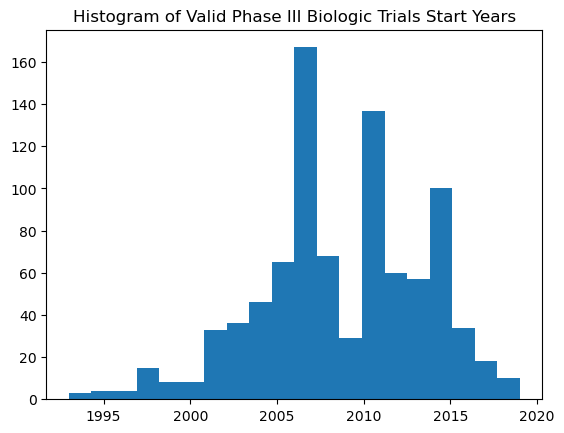

In [3]:
from random import shuffle 
import matplotlib.pyplot as plt
import sys
sys.path.append('benchmark/')
from data_split import csvfile2rows, row2year

input_file = 'data/raw_data2.csv'
output_file_name = 'data/phase_IIItemp.csv'
split_year=2014

rows = csvfile2rows(input_file)
years = [row2year(row) for row in rows]

plt.hist([y[0] for y in years if y[0]!=0.], bins=20)
plt.title('Histogram of Valid Phase III Biologic Trials Start Years')

In [4]:
import sys
sys.path.append('benchmark/')
from random import shuffle 

from data_split import filter_phase_II, filter_phase_III, csvfile2rows, check_pos_and_neg, write_row_to_csvfile, row2year
# select_and_split_data('data/raw_data2.csv', filter_phase_III, 'data/phase_IIItemp.csv')
def split_data(rows, split_year):
    learn_row = []
    test_row = []
    for row in rows:
        start_year, completion_year = row2year(row)
        # if 0 < completion_year < split_year:
        # 	learn_row.append(row)
        # elif 0 < start_year and start_year >= split_year:
        # 	test_row.append(row)
        if start_year >= split_year:
            test_row.append(row)
        else:
            learn_row.append(row)
    shuffle(learn_row)
    n = len(learn_row)
    train_num = int(n*0.9)
    train_row = learn_row[:train_num]
    valid_row = learn_row[train_num:]

    # n = len(rows)
    # train_num = int(n*train_valid_test_ratio[0])
    # valid_num = int(n*train_valid_test_ratio[1])	
    # train_row = rows[:train_num]
    # valid_row = rows[train_num:train_num + valid_num]
    # test_row = rows[train_num + valid_num:]
    return train_row, valid_row, test_row

input_file = 'data/raw_data2.csv'
output_file_name = 'data/phase_IIItemp.csv'
split_year=2014

rows = csvfile2rows(input_file)
rows = list(filter(filter_phase_III, rows))
print(len(rows))
# shuffle(rows)
positive_num = len(list(filter(lambda x:int(x[3])==1, rows)))
negative_num = len(rows) - positive_num 
print("\t\tpos =", str(positive_num), "  neg =", str(negative_num))
train_row, valid_row, test_row = split_data(rows, split_year)
print(len(train_row), len(valid_row), len(test_row))
fieldname = ['nctid', 'status', 'why_stop', 'label', 'phase', 
                'diseases', 'icdcodes', 'drugs', 'smiless', 'criteria']

print("train")
check_pos_and_neg(train_row)
print("valid")
check_pos_and_neg(valid_row)
print("test")
check_pos_and_neg(test_row)
output_file = output_file_name.replace('.csv', '_train.csv')
write_row_to_csvfile(train_row, fieldname, output_file)
output_file = output_file_name.replace('.csv', '_valid.csv')
write_row_to_csvfile(valid_row, fieldname, output_file)
output_file = output_file_name.replace('.csv', '_test.csv')
write_row_to_csvfile(test_row, fieldname, output_file)



752
		pos = 543   neg = 209
629 70 53
train
pos:  459  neg: 170
valid
pos:  49  neg: 21
test
pos:  35  neg: 18


In [5]:
### Drugbank tests

import pandas as pd
import numpy as np
drug_bank = pd.read_csv('data/drugbank_drugs_info.csv', sep=',', dtype={'title': str})
# np.unique(drug_bank['biotech_kind'].values.astype(str), return_counts=True)
print(drug_bank.columns)

drug_bank['title'] = drug_bank['title'].str.lower()
all_drugs = np.unique(drug_bank['title'].values)
all_drugs.tolist()

print(drug_bank[drug_bank['title']=='aldesleukin']['description.1'].values[0])
# print(drug_bank[drug_bank['title']=='proleukin'].values[0])
# print(all_drugs)
# for col in drug_bank.columns:
#     print(col, drug_bank[col])
# drug_bank.dtypes


/home/chufan2/miniconda3/envs/HINT/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['id', 'trial_id', 'kind', 'title', 'description', 'id.1',
       'intervention_id', 'drug_id', 'id.2', 'type', 'drugbank_id', 'name',
       'state', 'description.1', 'cas_number', 'protein_formula',
       'protein_weight', 'investigational', 'approved', 'vet_approved',
       'experimental', 'nutraceutical', 'illicit', 'withdrawn',
       'moldb_mono_mass', 'moldb_inchi', 'moldb_inchikey', 'moldb_smiles',
       'moldb_average_mass', 'moldb_formula', 'synthesis_patent_id',
       'protein_weight_details', 'biotech_kind'],
      dtype='object')
Aldesleukin, a lymphokine, is produced by recombinant DNA technology using a genetically engineered E. coli strain containing an analog of the human interleukin-2 gene. Genetic engineering techniques were used to modify the human IL-2 gene, and the resulting expression clone encodes a modified human interleukin-2. This recombinant form differs from native interleukin-2 in the following ways: a) Aldesleukin is not glycosylated because it 

In [12]:
import pandas as pd
data = pd.read_xml('data/drugbank_full_database.xml', parser='lxml', namespaces={"doc": "http://www.drugbank.ca"})

In [ ]:
data

In [ ]:
print(data.columns)
data[data['name']=='proleukin'].values
# print(sorted(data.name.values))

In [52]:
import lxml.etree as etree

x = etree.parse("data/drugbank_full_database.xml")
print(etree.tostring(x, pretty_print=True))


In [ ]:
import xml.etree.ElementTree as ET

xml_data = open('data/drugbank_full_database.xml', 'r').read()  # Read file
root = ET.XML(xml_data)  # Parse XML

data = []
cols = []
for i, child in enumerate(root):
    data.append([subchild.text for subchild in child])
    cols.append(child.tag)

    print(data, cols)
    break
